In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import itertools                                  # для первого задания
from fbprophet import Prophet                     # для второго задания

import seaborn as sns

## Задание 1

В файле содержится информация о покупках людей

- id – означает покупку (в одну покупку входят все товары, купленные пользователем во время 1 похода в магазин)
- Товар – наименование товара
- Количество – число единиц купленного товара

Воспользуйтесь этими данными и выясните, какие пары товаров пользователи чаще всего покупают вместе. 

- 1_Товар – наименование первого товара
- 2_Товар – наименование второго товара
- Встречаемость – число раз, когда такая пара была встречена

In [2]:
task_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409319/test1_completed.csv')

In [18]:
# переименовываю колонки для удобства
task_1 = task_1.rename(columns={'Товар' : 'item'}) \
               .sort_values(['id', 'item'])



In [7]:
# основные расчеты 
df_1 = pd.DataFrame()
for id in task_1.id.unique():
    items = task_1[task_1.id == id]['item'].str.cat(sep=',').split(',')
    items_pair  = list(itertools.combinations(items,2))
    df = pd.DataFrame(items_pair)
    df.insert(loc = df.shape[1], column='2', value=id)
    df_1 = df_1.append(df, ignore_index=True)
print(df_1)

                        0                 1       2
0                   Лимон   Лимон оранжевый   17119
1                   Лимон      Лук репчатый   17119
2                   Лимон         Лук-порей   17119
3                   Лимон     Малина свежая   17119
4                   Лимон   Морковь немытая   17119
...                   ...               ...     ...
390538  Фасоль стручковая   Черешня сушеная  119396
390539  Фасоль стручковая  Яблоки Джонаголд  119396
390540            Физалис   Черешня сушеная  119396
390541            Физалис  Яблоки Джонаголд  119396
390542    Черешня сушеная  Яблоки Джонаголд  119396

[390543 rows x 3 columns]


In [8]:
#переименовываю колонки в получившейся таблицу и вывожу топ 5 по совместной встречаемости
df_1 = df_1.rename(columns= {0:'1_Товар', 1:'2_Товар', '2':'Встречаемость'})

df_1.groupby(['1_Товар', '2_Товар'], as_index=False) \
    .agg({'Встречаемость':'count'}) \
    .sort_values('Встречаемость', ascending=False).head()

,1_Товар,2_Товар,Встречаемость
16429,Огурцы Луховицкие,Укроп,431
17542,Петрушка,Укроп,408
1785,Арбуз,Огурцы Луховицкие,345
9679,Кабачки,Огурцы Луховицкие,326
11392,Кинза,Укроп,303


## Задание 2

К вам поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%

Примечание: я хотел воспользоваться __sklearn__ и его функциями _LinearRegression_ и _train_test_split_ для расчета линейной регресии и затем использовать __datetime__ для создание требуемого для анализа времянного ряда, но у меня не получилось разобраться с типами данных, которые необходимо подвать в функцию _model.predict()_ , поэтому я попробовал использовать для предсказания __prophet__ , который мы проходили в модуле по sql

In [5]:
# Загружаю данные
task_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv')

In [6]:
# Смотрю тип переменых и названия колонок
task_2.dtypes

Дата             object
Число заказов     int64
dtype: object

In [7]:
# меняю название колонок на удобное для работы и перевожу даты во временной формат
task_2 = task_2.rename(columns={'Дата' : 'Date', 'Число заказов': 'orders'})

task_2['Date'] = pd.to_datetime(task_2.Date)

In [8]:
# выставляю параметры графика
sns.set(
    font_scale = 1,
    style       = 'whitegrid',
    rc          ={'figure.figsize': (15,4)})

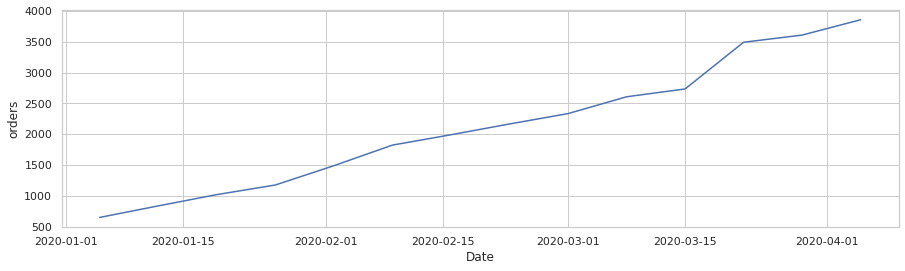

In [9]:
# оцениваю визуально данные.
sns.lineplot(data=task_2, x ='Date', y='orders')

Я предпологаю, что модель будет учитывать 7% увеличение роста продаж, поэтому просто строю модель на тех данных что есть, не добавляя дополнительных аргументов.

In [10]:
# переименовываю колонки для prohet
task_2 = task_2.rename(columns={'Date' : 'ds', 'orders': 'y'})

# Период, который надо отрезать и предсказать (проверка модели)
predictions = 7

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = task_2[:-predictions]

In [11]:
# Настраиваем prophet
m = Prophet( weekly_seasonality=False, yearly_seasonality=False)
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


In [12]:
# беру период 49 так как я отрезал 7 недель
future = m.make_future_dataframe(periods=49)
forecast = m.predict(future)

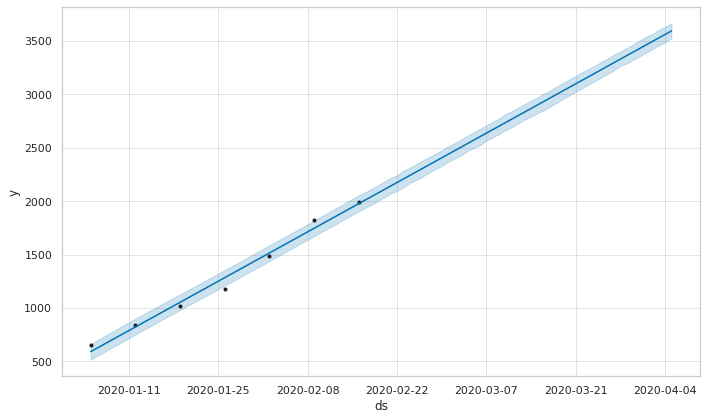

In [13]:
# Смотрим, что предсказалось
m.plot(forecast);

In [15]:
#сравниваю модель с реальными данными. Видно, что модель предсказывает схожие значения
task_2

,ds,y
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


In [16]:
# использую модель для предсказания следующих 3х месяцев
prediction_days = 90
final_train_df = task_2
f = Prophet(weekly_seasonality=False, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


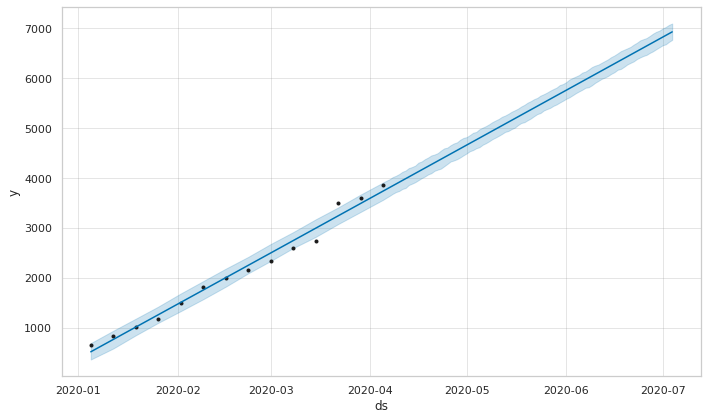

In [17]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast);

##  Задание 3 (PostgreSQL)

В базе данных вашей компании присутствуют следующие таблицы

__city__
- city_id – id города, где проходит акция
- client_city_id – id города, где находится покупатель
- city – город
- client_city – город, где находится покупатель

__client__
- client_id – id покупателя
- client_city_id – id города, где находится покупатель
- birth_date – дата рождения покупателя
- registration – дата регистрации покупателя
- promotion
- promotion_id – id акции
- category_id – id категории
- promotion_name – акция
- category_name – категория
- partner_id – id партнёра
- partner_name – партнёр

__purchase__
- purchase_id – id покупки
- partner_id – id партнёра
- client_id – id покупателя
- city_id – id города
- promotion_id – id акции
- category_id – id категории
- purchase_date – дата покупки
- price – цена за единицу товара
- quantity – число проданных единиц
- status – статус покупки

Вам нужно написать запрос, чтобы получить такую таблицу

- purchase_date – дата покупки
- purchase_id – id покупки
- client_id – id покупателя
- client_age – возраст покупателя
- client_registration_age – как долго человек пользуется вашими магазинами
- client_category – содержит new или old, если это первая или последующая покупка соответственно
- promotion_name – акция
- category_name – категория
- partner_name – партнёр
- client_city – город, где находится покупатель
- city – город
- revenue – сумма выручки
- quantity – число проданных единиц

При этом в таблице должны присутствовать только значения, где в поле status стоит значение 1, и только те, где purchase_date находится в диапазоне от 01.05.2020 до 01.08.2020

`SELECT 
    a.purchase_date AS purchase_date,
    a.purchase_id AS purchase_id,
    a.client_id AS client_id,
    c.client_age AS client_age,
    c.client_registration_age AS client_registration_age,
    a.client_category AS client_category,
    a.promotion_name AS promotion_name,
    a.category_name AS category_name,
    a.partner_name  AS partner_name,
    c.client_city AS client_city,
    c.city AS city,
    a.revenue AS revenue,
    a.quantity AS quantity
FROM
    (
    SELECT *
    FROM
        (
        SELECT *,
            multiply(price, quantity) AS revenue
        FROM purchase AS l
        LEFT JOIN
            (
            SELECT 
                client_id,
                IF(COUNT(client_id) > 1, 'old', 'new') AS client_category
            FROM purchase
            GROUP BY client_id
            ) AS r 
            USING(client_id)
        ) AS a
    LEFT JOIN promotion AS b  
        USING(promotion_id)
    ) AS a
LEFT JOIN 
    (
    SELECT
        l.city AS city,
        l.client_city AS client_city,
        r.client_id AS client_id,
        r.client_age AS client_age,
        r.client_registration_age AS client_registration_age
    FROM city AS l
    JOIN 
        (
        SELECT
            client_id,
            client_city_id,
            dateDiff('year', birth_date, now()) AS client_age,
            dateDiff('year', registration, now()) AS client_registration_age
        FROM client
        ) AS r
        ON l.client_city_id = r.client_city_id
    ) AS c
    ON a.client_id = c.client_id
WHERE status = 1
    AND purchase_date > '2020-05-01'
    AND purchase_date < '2020-08-01'
ORDER BY purchase_date`